In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.agents.stablebaselines3.models_syn import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

In [7]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [8]:
RESULTS_DIR

'results'

In [9]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2015-09-26'
TEST_START_DATE = '2015-09-26'
TEST_END_DATE = '2023-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TEST_END_DATE,
                    ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,macds,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
59531,2017-02-28,122.050003,122.959999,121.790001,105.771339,1966000,TRV,1,0.965576,0.757974,107.278621,100.258685,61.772832,125.604169,19.324126,103.164256,103.280066,8.739139
1972,2009-04-13,4.286071,4.320714,4.250000,3.649289,389236400,AAPL,0,0.186795,0.158372,3.732841,2.865568,66.310324,132.820021,53.473658,3.108423,2.944763,0.000000
74934,2019-04-09,54.779999,55.029999,54.360001,45.562248,8987700,WBA,1,-2.482300,-2.028633,56.682930,44.114989,31.480838,-153.958404,50.772328,51.427942,55.533099,9.876101
27026,2012-09-12,35.209999,35.490002,35.110001,25.795805,3969600,WBA,2,0.135733,0.251143,26.320125,25.480127,57.109408,-90.020108,7.998096,25.949225,24.324543,17.034181
23571,2012-03-23,58.160000,58.360001,57.959999,44.967690,2986500,TRV,4,0.038834,0.003323,46.069210,43.692534,50.705762,-31.420266,2.876700,45.054601,45.317950,17.678963


In [12]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 320


In [13]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [14]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [15]:
rebalance_window = 66 # rebalance_window is the number of days to retrain the model
validation_window = 66 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [16]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.8607249762903979


In [17]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2015-12-31,NaN,2015-12-31
1,999279.904000,2016-01-04,-0.000720,2016-01-04
2,998917.820264,2016-01-05,-0.000362,2016-01-05
3,997459.589685,2016-01-06,-0.001460,2016-01-06
4,993439.277553,2016-01-07,-0.004031,2016-01-07


<AxesSubplot:>

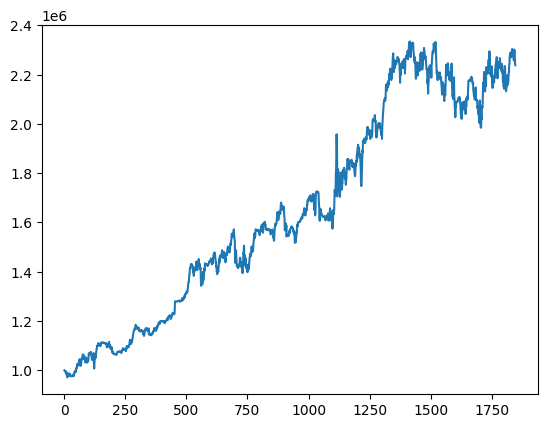

In [18]:
%matplotlib inline
df_account_value.account_value.plot()

In [19]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.116091
Cumulative returns     1.237676
Annual volatility      0.138944
Sharpe ratio           0.860725
Calmar ratio           0.774253
Stability              0.950736
Max drawdown          -0.149939
Omega ratio            1.178377
Sortino ratio          1.235783
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.084922
Daily value at risk   -0.017031
dtype: float64


In [20]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1847, 8)
Annual return          0.092896
Cumulative returns     0.917600
Annual volatility      0.189607
Sharpe ratio           0.564159
Calmar ratio           0.250487
Stability              0.868292
Max drawdown          -0.370862
Omega ratio            1.121650
Sortino ratio          0.779705
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.905842
Daily value at risk   -0.023464
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1847, 8)


Start date,2015-12-31
End date,2023-05-04
Total months,88
,Backtest
Annual return,11.609%
Cumulative returns,123.768%
Annual volatility,13.894%
Sharpe ratio,0.86
Calmar ratio,0.77
Stability,0.95
Max drawdown,-14.994%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.99,2021-08-16,2022-10-12,NaT,NaN
1,12.96,2020-06-08,2020-06-26,2020-12-02,128
2,11.30,2018-10-03,2018-11-23,2019-02-13,96
3,9.72,2019-07-15,2019-10-02,2019-12-16,111
4,8.78,2020-02-12,2020-05-13,2020-05-27,76


Stress Events,mean,min,max
New Normal,0.05%,-8.75%,4.43%


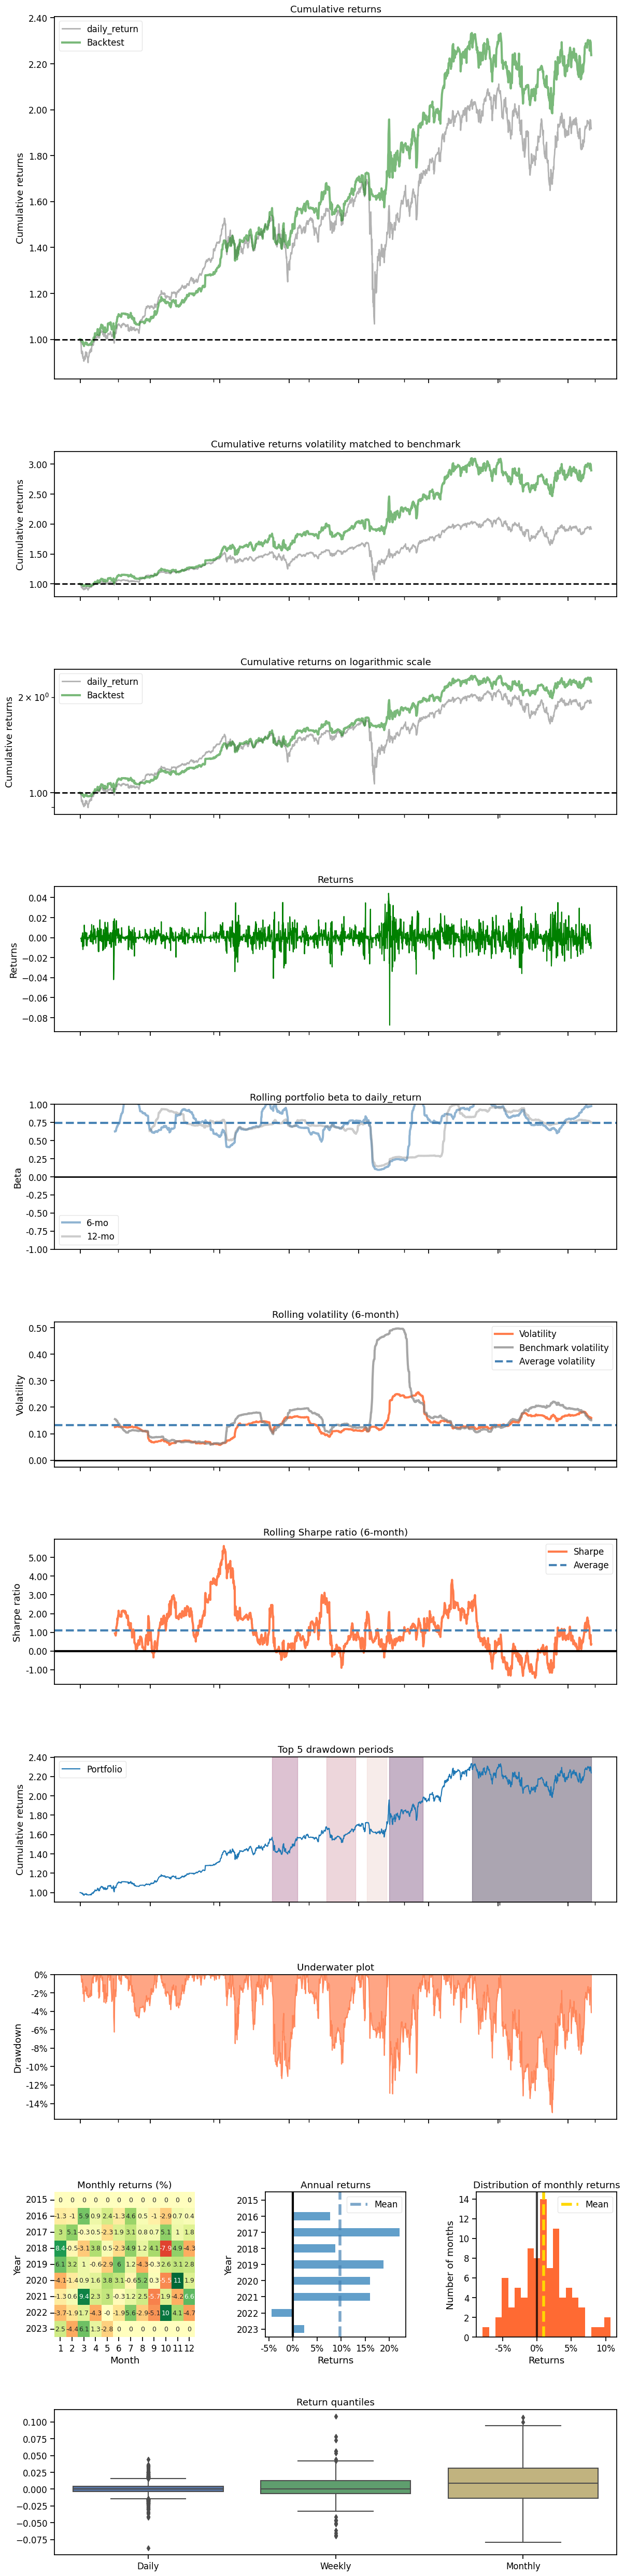

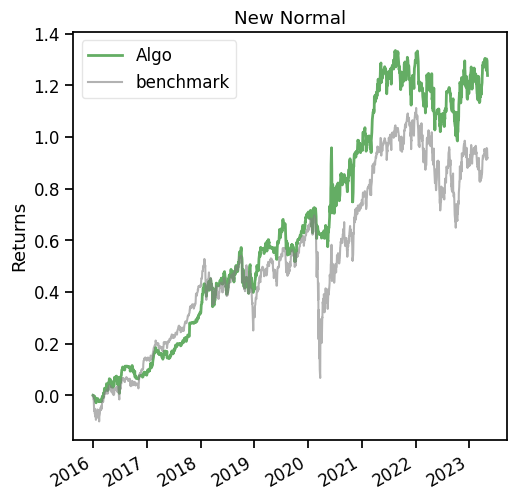

In [21]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])